In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add project 1 to sys path 
import sys
sys.path.append('../project1/')
import tools as proj1_tools

import numpy as np
import matplotlib.pyplot as plt
import project2_tools as tools

from sklearn.linear_model import Lasso

from IPython.display import clear_output

## One dimensional Ising model with linear regression

Generate data

In [641]:
L = 40
n = 1000

X,E = tools.gen_1Ddata(L,n) 

(1000, 1601)

Fit the linear models and get the parameters; the coupling constant $J$

In [24]:
# OLS
regr_ols = proj1_tools.Regression(X, E, solve_method = 'svd')
J_fit_ols = regr_ols.beta

# Ridge and Lasso
lambdas = np.array([1e-05,1e-04,1e-03,1e-02,1e-01])

J_fit_ridge = []
J_fit_lasso = []

for i,lmbd in enumerate(lambdas):
    print('Lambdas: ',i+1,'/',lambdas.shape[0])
    regr_ridge = proj1_tools.Regression(X_vectors, E, lmbd = lmbd, solve_method = 'svd')
    J_fit_ridge.append(regr_ridge.beta)
    regr_lasso = Lasso(alpha=lmbd, fit_intercept=False)
    J_fit_lasso.append(regr_lasso.fit(X_vectors, E).coef_)
    clear_output(wait=0.1)

Lambdas:  5 / 5


### Plot

Parameters as matrix:

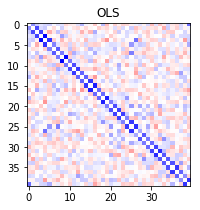

Lambda =  1e-05


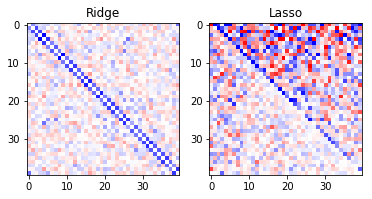

Lambda =  0.0001


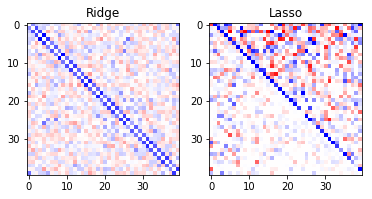

Lambda =  0.001


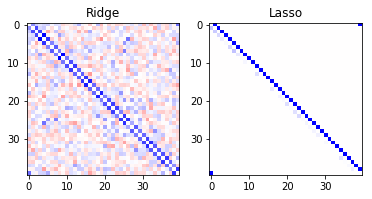

Lambda =  0.01


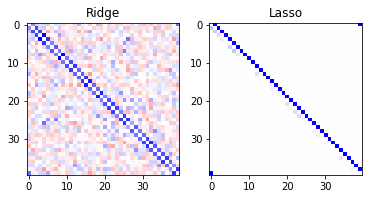

Lambda =  0.1


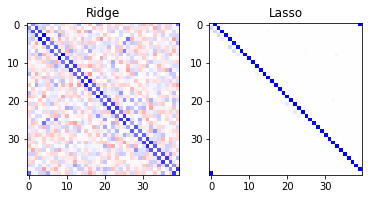

In [11]:
vmin = np.min(J_fit_ols)
assert vmin < 0
# OLS
plt.figure(figsize=[3,3])
plt.title('OLS')
plt.imshow(J_fit_ols.reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
plt.show()
# Ridge and Lasso
for i,lmbd in enumerate(lambdas):
    print('Lambda = ',lmbd)
    fig,[ax1,ax2] = plt.subplots(1,2)
    ax1.imshow(J_fit_ridge[i].reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
    ax1.set_title('Ridge')
    ax2.imshow(J_fit_lasso[i].reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
    ax2.set_title('Lasso')
    plt.show()
# plt.colorbar(m)

Histogram of paramters:

Lambda =  1e-10


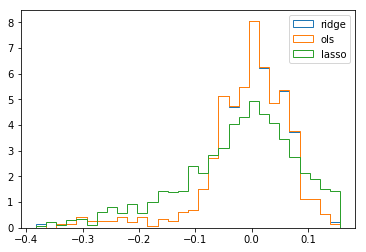

Lambda =  1e-09


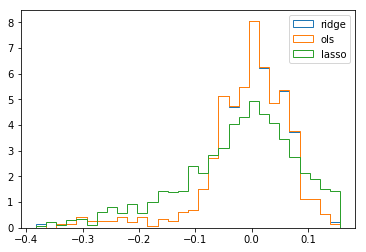

Lambda =  1e-08


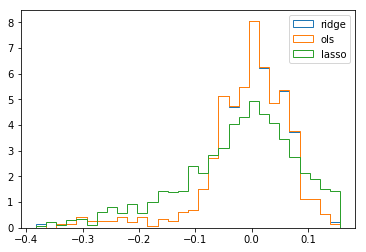

Lambda =  1e-07


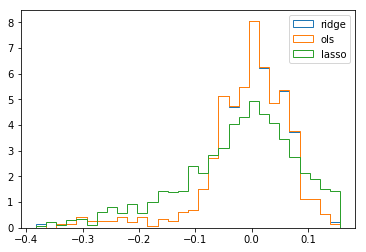

Lambda =  1e-06


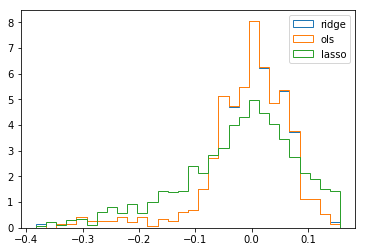

Lambda =  1e-05


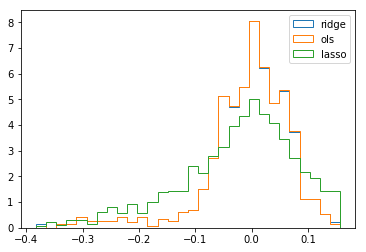

Lambda =  0.0001


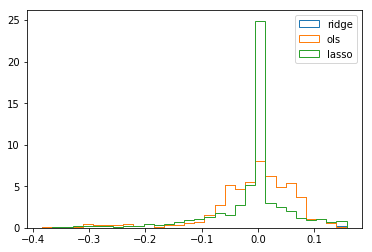

Lambda =  0.001


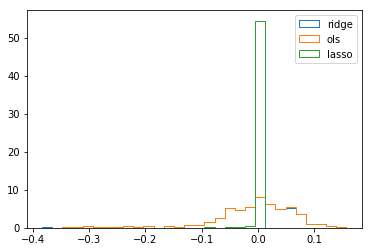

Lambda =  0.01


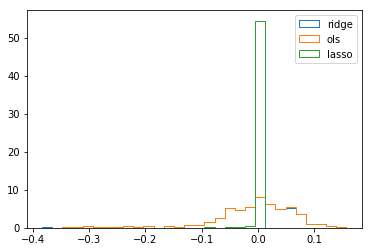

Lambda =  0.1


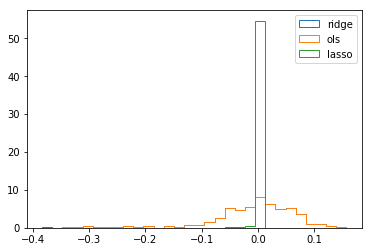

Lambda =  1.0


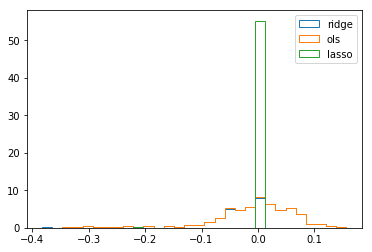

In [7]:
for i,lmbd in enumerate(lambdas):
    print('Lambda = ',lmbd)
    _,bins,_ = plt.hist(J_fit_ridge[i], bins = 30, histtype='step',density = True, label='ridge')
    _ = plt.hist(J_fit_ols, bins = bins, histtype='step', density = True, label='ols')
    _ = plt.hist(J_fit_lasso[i], bins = bins, histtype='step', density = True, label='lasso')
    plt.legend()
    plt.show()

# Performance with mse and r2

In [518]:
import time
from sklearn.linear_model import Lasso

L = 40 # Lattice size
n = 1000 # number of samples

X,y = tools.gen_1Ddata(L,n, ret_pairs = True)
n_train = 666
#n_train = X.shape[0] - 1000
X_train = X[:n_train][:]
y_train = y[:n_train]
X_test = X[n_train:][:]
y_test = y[n_train:]

mse_in_ols = []
mse_out_ols = []
r2_in_ols = []
r2_out_ols = []
beta_ols = []

mse_in_ridge = []
mse_out_ridge = []
r2_in_ridge = []
r2_out_ridge = []
beta_ridge = []

mse_in_lasso = []
mse_out_lasso = []
r2_in_lasso = []
r2_out_lasso = []
beta_lasso = []

lmbds = np.logspace(-4, 5, 10)

left = lmbds.shape[0]
time_tot = 0
t1 = time.time()

lasso = Lasso()

for i,lmbd in enumerate(lmbds):
    if i == 0:
        print(i+1,'/',left,' - lmbd = ',lmbd,' - estimating time...')
        #OLS
        ols = proj1_tools.Regression(X_train,y_train, lmbd = 0,
                        solve_method = 'svd')
        for i in range(left):
            beta_ols.append(ols.beta)
            mse_in_ols.append(proj1_tools.squared_error(ols.yhat,y_train))
            r2_in_ols.append(proj1_tools.r2score(y_train,ols.predict(X_train)))
            ypred_ols = ols.predict(X_test)
            mse_out_ols.append(proj1_tools.squared_error(ypred_ols,y_test))
            r2_out_ols.append(proj1_tools.r2score(y_test,ypred_ols))
    
    t2 = time.time()
    time_tot += (left-i)*(t2-t1)
    if i > 0:
        print(i+1,'/',left,' - lmbd = ',lmbd,' - estimated time left: ',round((left-i)*(t2-t1)),'s')
        
    ##RIDGE
    ridge = proj1_tools.Regression(X_train,y_train, lmbd = lmbd,
                    solve_method = 'svd')
    beta_ridge.append(ridge.beta) 
    mse_in_ridge.append(proj1_tools.squared_error(ridge.yhat, y_train))
    r2_in_ridge.append(proj1_tools.r2score(y_train,ridge.predict(X_train)))
    ypred_ridge = ridge.predict(X_test)
    mse_out_ridge.append(proj1_tools.squared_error(ypred_ridge,y_test))
    r2_out_ridge.append(proj1_tools.r2score(y_test, ypred_ridge))
    
    #LASSO
    lasso.set_params(alpha=lmbd) 
    lasso.fit(X_train, y_train) 
    ypred_lasso_train = lasso.predict(X_train)
    beta_lasso.append(lasso.coef_) 
    mse_in_lasso.append(proj1_tools.squared_error(ypred_lasso_train, y_train))
    r2_in_lasso.append(lasso.score(X_train, y_train))
    ypred_lasso = lasso.predict(X_test)
    mse_out_lasso.append(proj1_tools.squared_error(ypred_lasso,y_test))
    r2_out_lasso.append(lasso.score(X_test, y_test))
    
    t1 = t2
    clear_output(wait=0.1)

clear_output(wait=0.1)
print('Done! total time: ',round(time_tot))

Done! total time:  147


### Plot mean squared error

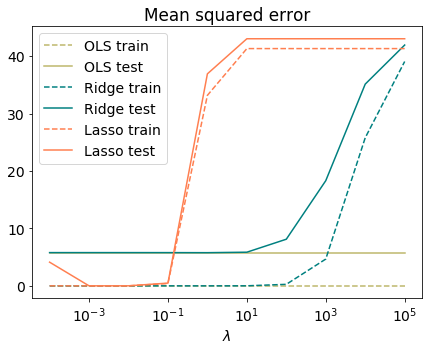

In [635]:
x = np.logspace(-4, 5, 10)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [7,5])
plt.semilogx(x,mse_in_ols,'--',color='darkkhaki',label='OLS train')
plt.semilogx(x,mse_out_ols,'-',color='darkkhaki',label='OLS test')
plt.semilogx(x,mse_in_ridge,'--',color='teal',label='Ridge train')
plt.semilogx(x,mse_out_ridge,'-',color='teal',label='Ridge test')
plt.semilogx(x,mse_in_lasso,'--',color='coral',label='Lasso train')
plt.semilogx(x,mse_out_lasso,'-',color='coral',label='Lasso test')
plt.legend()
#plt.ylabel('Accuracy score')
plt.xlabel(r'$\lambda$')
plt.title('Mean squared error')

#plt.ylim([-0.1,1.1])
plt.savefig('MSE.pdf')

### Plot R2 score

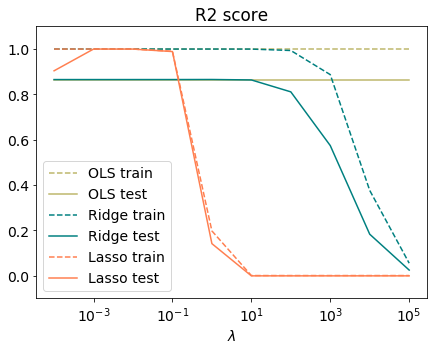

In [519]:
x = lmbds
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [7,5])
plt.semilogx(x,r2_in_ols,'--',color='darkkhaki',label='OLS train')
plt.semilogx(x,r2_out_ols,'-',color='darkkhaki',label='OLS test')
plt.semilogx(x,r2_in_ridge,'--',color='teal',label='Ridge train')
plt.semilogx(x,r2_out_ridge,'-',color='teal',label='Ridge test')
plt.semilogx(x,r2_in_lasso,'--',color='coral',label='Lasso train')
plt.semilogx(x,r2_out_lasso,'-',color='coral',label='Lasso test')
plt.legend()
#plt.ylabel('Accuracy score')
plt.xlabel(r'$\lambda$')
plt.title('R2 score')

plt.ylim([-0.1,1.1])
plt.savefig('R2score_1D.pdf')

### Plot parameters

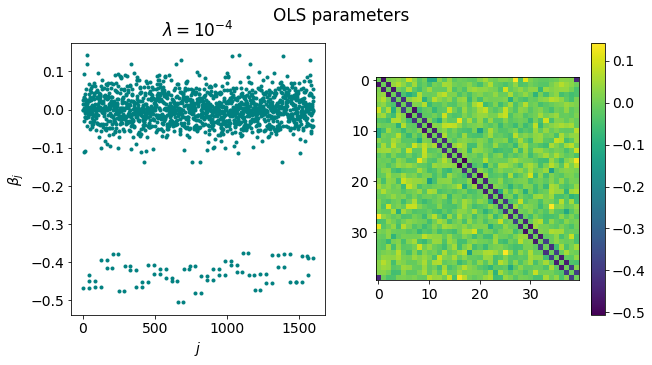

In [549]:
plt.tight_layout
plt.figure(figsize = [10,5])
plt.subplot(121)
plt.plot(beta_ols[0],'.',color='teal')
plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-4}$')
plt.subplot(122)
bar = plt.imshow(beta_ols[0][1:].reshape(40,40),cmap='viridis')
plt.colorbar(bar)
plt.rcParams.update({'font.size': 14})

plt.suptitle('OLS parameters')
plt.savefig('param_ols.pdf')

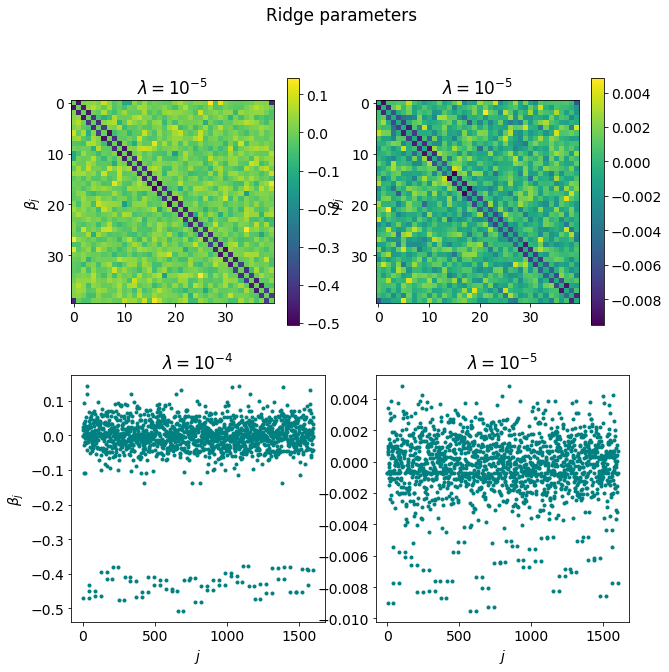

In [551]:
plt.tight_layout
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [10,10])
plt.subplot(2,2,3)
plt.plot(beta_ridge[0],'.',color='teal')
plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-4}$')
#plt.ylim([-0.6,0.1])
plt.subplot(2,2,4)
plt.plot(beta_ridge[9],'.',color='teal')
plt.xlabel('$j$')
#plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-5}$')
#plt.ylim([0.1,-0.6])
plt.subplot(2,2,1)
bar = plt.imshow(beta_ridge[0][1:].reshape(40,40))
plt.colorbar(bar)
#plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-5}$')
plt.subplot(2,2,2)
bar = plt.imshow(beta_ridge[9][1:].reshape(40,40))
plt.colorbar(bar)
#plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-5}$')
#plt.title(r'$\lambda=10^{-5}$')


plt.suptitle('Ridge parameters')
plt.savefig('param_ridge.pdf')

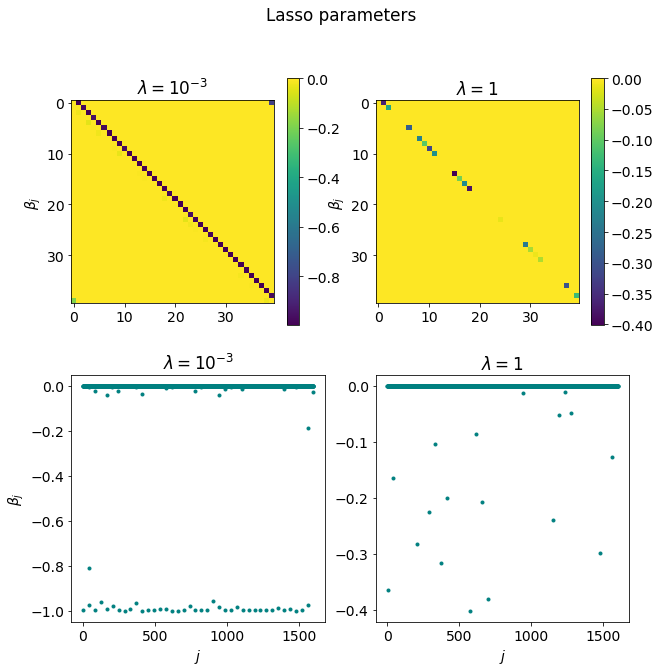

In [552]:
plt.tight_layout
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [10,10])
plt.subplot(2,2,3)
plt.plot(beta_lasso[1],'.',color='teal')
plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-3}$')
#plt.ylim([-0.6,0.1])
plt.subplot(2,2,4)
plt.plot(beta_lasso[4],'.',color='teal')
plt.xlabel('$j$')
#plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=1$')
#plt.ylim([0.1,-0.6])
plt.subplot(2,2,1)
bar = plt.imshow(beta_lasso[1][1:].reshape(40,40))
plt.colorbar(bar)
#plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=10^{-3}$')
plt.subplot(2,2,2)
bar = plt.imshow(beta_lasso[4][1:].reshape(40,40))
plt.colorbar(bar)
#plt.xlabel('$j$')
plt.ylabel(r'$\beta_j$')
plt.title(r'$\lambda=1$')
#plt.title(r'$\lambda=10^{-5}$')


plt.suptitle('Lasso parameters')
plt.savefig('param_lasso.pdf')

# Resampling
Using Bootstrap

In [263]:
def resample(X,y,smplsize=1000):
    """
    Resample dataset using bootstrap.
    """
    indx = np.arange(X.shape[0])
    nrnd = np.random.choice((X.shape[0]), size = smplsize)
    nuniq = np.unique(nrnd)
    X_train = X[nrnd][:]
    y_train = y[nrnd]
    mask = np.zeros_like(np.arange(X.shape[0]),dtype=bool)
    mask[nuniq] = True
    X_test = X[~mask][:]
    y_test = y[~mask]
    return X_test,y_test

In [568]:
#import numpy as np
#import bias_var
#import proj2_tools as tools
from sklearn.model_selection import train_test_split
import time

n = 1000
L = 40
X,y = tools.gen_1Ddata(L,n, ret_pairs = True, fit_intercept=True)

n_boots = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lmbds = np.logspace(-8,3,12)
#lmbd = 1e-02

y_pred_ridge = np.empty((y_test.shape[0], n_boots))
y_pred_lasso = np.empty((y_test.shape[0], n_boots))
#r2 = np.empty((lmbds.shape[0]))
error_ridge = np.empty((lmbds.shape[0]))
bias_ridge = np.empty((lmbds.shape[0]))
variance_ridge = np.empty((lmbds.shape[0]))
error_lasso = np.empty((lmbds.shape[0]))
bias_lasso = np.empty((lmbds.shape[0]))
variance_lasso = np.empty((lmbds.shape[0]))

for j,lmbd in enumerate(lmbds):
    t1 = time.time()
    for i in range(n_boots):
        t2 = time.time()
        if i == 0 :
            print('{}/{}, Estimating time ...'.format((i+1),n_boots))
        else:
            print('{}/{}, Estimated time: {}s'.format((i+1),n_boots,
                                                      round((t2-t1)*(n_boots-i)) ))
        X_boot, y_boot = resample(X_train, y_train,smplsize=y_train.shape[0])
        ypred_ridge = proj1_tools.Regression(X_boot, y_boot,lmbd=lmbd,solve_method='svd').predict(X_test)
        lasso = Lasso(alpha=lmbd)
        lasso.fit(X_boot, y_boot)
        ypred_lasso = lasso.predict(X_test)

        #r2[i] = proj1_tools.r2score(ypred,y_test)
        y_pred_ridge[:,i] = (ypred_ridge.ravel())
        y_pred_lasso[:,i] = (ypred_lasso.ravel())
        
        t1 = t2
        
    bias_ridge[i] = np.mean( (y_test - np.mean(y_pred_ridge, axis=1))**2 )
    variance_ridge[i] = np.mean( np.var(y_pred_ridge, axis=1, keepdims=True) ) 
    error_ridge[i] = np.mean( np.mean((y_test - y_pred_ridge.T)**2, axis=1, keepdims=True) )
    bias_lasso[i] = np.mean( (y_test - np.mean(y_pred_lasso, axis=1))**2 )
    variance_lasso[i] = np.mean( np.var(y_pred_lasso, axis=1, keepdims=True) ) 
    error_lasso[i] = np.mean( np.mean((y_test - y_pred_lasso.T)**2, axis=1, keepdims=True) )


1/10, Estimating time ...
2/10, Estimated time: 21s
3/10, Estimated time: 16s
4/10, Estimated time: 19s
5/10, Estimated time: 13s
6/10, Estimated time: 10s
7/10, Estimated time: 8s
8/10, Estimated time: 6s
9/10, Estimated time: 4s
10/10, Estimated time: 2s
1/10, Estimating time ...
2/10, Estimated time: 19s
3/10, Estimated time: 16s
4/10, Estimated time: 13s
5/10, Estimated time: 11s
6/10, Estimated time: 10s
7/10, Estimated time: 12s
8/10, Estimated time: 7s
9/10, Estimated time: 4s
10/10, Estimated time: 2s
1/10, Estimating time ...
2/10, Estimated time: 17s
3/10, Estimated time: 15s
4/10, Estimated time: 13s
5/10, Estimated time: 11s
6/10, Estimated time: 9s
7/10, Estimated time: 7s
8/10, Estimated time: 6s
9/10, Estimated time: 4s
10/10, Estimated time: 2s
1/10, Estimating time ...
2/10, Estimated time: 17s
3/10, Estimated time: 20s
4/10, Estimated time: 19s
5/10, Estimated time: 13s
6/10, Estimated time: 12s
7/10, Estimated time: 8s
8/10, Estimated time: 8s
9/10, Estimated time: 7

### Plot

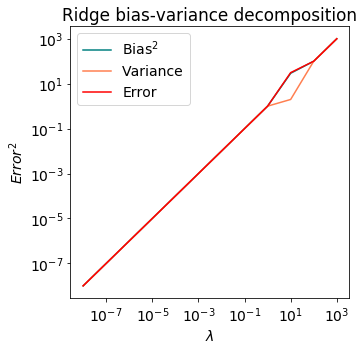

In [619]:
plt.tight_layout
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = [5,5])
plt.loglog(lmbds,bias_ridge,'-',color='teal',label=r'Bias$^2$')
plt.loglog(lmbds,variance_ridge,'-',color='coral',label='Variance')
plt.loglog(lmbds,error_ridge,'r-',label='Error')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Error^2$')
plt.title('Ridge bias-variance decomposition')
plt.savefig('ridge_bvd.pdf')